**RNA-ADT Vertical Integration (HLN)**

*Config*

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import argparse
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from SpaMode.utils import clustering
from SpaMode.preprocess import clr_normalize_each_cell, pca
from SpaMode.preprocess import fix_seed

fix_seed(2024)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import json
with open("config/cfg_training.json", "r") as file:
    config = json.load(file)
    cfg = config["HLN"]["A1"]

*Data preprocess*

In [2]:
print('Loading Data...')
adata_omics_list = []
if cfg['RNA_Path'] != '':
    adata_omics1 = sc.read_h5ad(cfg['RNA_Path'])
    adata_omics1.var_names_make_unique()
    sc.pp.filter_genes(adata_omics1, min_cells=10)
    sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata_omics1, target_sum=1e4)
    sc.pp.log1p(adata_omics1)
    sc.pp.scale(adata_omics1)
    adata_omics1_high = adata_omics1[:, adata_omics1.var['highly_variable']]
    adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=30)
    adata_omics_list.append(adata_omics1)
    print('RNA Feat:')
    print(adata_omics1)
if cfg['ADT_Path'] != '':
    adata_omics2 = sc.read_h5ad(cfg['ADT_Path'])
    adata_omics2.var_names_make_unique()
    adata_omics2 = clr_normalize_each_cell(adata_omics2)
    sc.pp.scale(adata_omics2)
    adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=30)
    adata_omics_list.append(adata_omics2)
    print('ADT Feat:')
    print(adata_omics2)


Loading Data...


/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


RNA Feat:
AnnData object with n_obs × n_vars = 3484 × 17954
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'feat'
ADT Feat:
AnnData object with n_obs × n_vars = 3484 × 31
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    obsm: 'spatial', 'feat'


/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


*Construct graph*

In [3]:
from SpaMode.preprocess import construct_neighbor_graph_SpaMode
data = construct_neighbor_graph_SpaMode(adata_omics_list, datatype='10x',
                                        Spatial_neighbors=3, Feature_neighbors=20)

Spatial_neighbors = 3
Feature_neighbors = 20


*Define SpaMode*

In [4]:
from SpaMode.Train import Train_SpaMode
model = Train_SpaMode(data, datatype='10x', device=device, Arg=cfg)

/home/hxl/Spa_Multi-omics/SpaMode/SpaMode/preprocess.py:205: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


tensor([0.4940, 0.5060], device='cuda:0')


/home/hxl/Spa_Multi-omics/SpaMode/SpaMode/Train.py:285: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight = F.softmax(differ_stack)


*Training SpaMode*

In [5]:
output = model.train()

optimizer:  AdamW


 74%|███████▍  | 741/1000 [01:28<00:30,  8.36it/s, Biloss=1.68, adv_loss=0.238, kl_loss=0.673, moe_loss=0.00661, recon=17.3] 

Early Stop
Model training finished!



*clustering*

In [6]:
adata = adata_omics1.copy()
adata.obsm['SpaMode'] = output['SpaMode'].copy()
tool = 'mclust'  # mclust, leiden, and louvain
n_clusters=10
print('n_clusters:', n_clusters)
clustering(adata, key='SpaMode', add_key='SpaMode', n_clusters=n_clusters, method=tool, use_pca=True)
label_list = adata.obs['SpaMode'].tolist()
adata.obs['Our_label'] = np.array(label_list).astype(str)
adata.obs['Our_label'] = adata.obs['Our_label'].astype('category')

n_clusters: 10


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


*Visualization*

/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


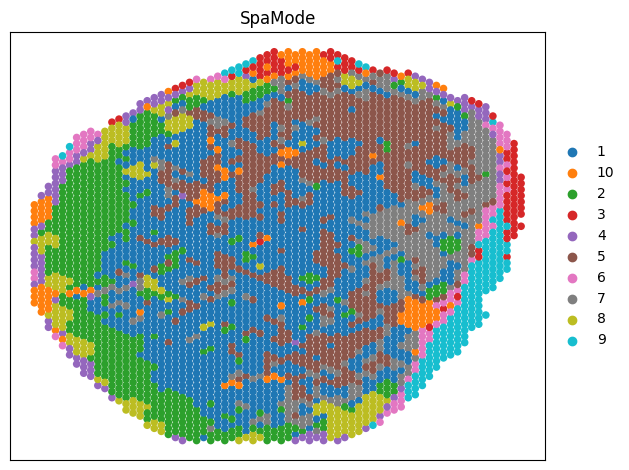

In [7]:
fig = sc.pl.embedding(adata, basis='spatial', color='Our_label', title='SpaMode', s=120, show=False, return_fig=True)

ax = fig.axes[0]
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout(w_pad=0.3)
plt.show()

*Metrics*

In [8]:
from cal_matrics import eval
txt_out_path = '/home/hxl/Spa_Multi-omics/SpaMode/Results/HLN/SpaMode_A1.txt'
eval_save_path = '/home/hxl/Spa_Multi-omics/SpaMode/Results/HLN/SpaMode_A1_metrics.txt'

with open(txt_out_path, 'w') as f:
    for num in label_list:
        f.write(f"{num}\n")
        
eval(cfg['GT_path'], txt_out_path, eval_save_path)

0 9
1 10
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
3484
3484
our         jaccard: 0.316279
our         F_measure: 0.480566
our         Mutual Information: 0.730142
Our         (NMI): 0.407188
Our         (AMI): 0.403157
Our         V-measure: 0.407188
Our         Homogeneity: 0.432804 Completeness: 0.384435
Our         (ARI): 0.342526
Our         (FMI): 0.482081
